In [27]:
import pandas as pd
import contractions
import re
import csv
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, BartTokenizer, BartForConditionalGeneration
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import bert_score

In [28]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove URLs
    text = re.sub(r'(http[s]?://\S+|www\.\S+)', '', text)

    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Split numbers and chars
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])|(?<=[a-zA-Z])(?=\d)', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [29]:
def expand(text):
    with open('abbreviations.csv', mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        abbreviations = {rows[0]: rows[1] for rows in reader}

    words = text.split()
    for i in range(len(words)):
        word = words[i].lower()
        if word in abbreviations:
            if (word != 'pm') or (word == 'pm' and i > 0 and words[i-1].isalpha()):
                words[i] = abbreviations[word]
    return ' '.join(words)

In [30]:
def preprocessing(path):
    try:
        df = pd.read_csv(path)
        output_file = path.split('.')[0] + '_preprocessed.csv'

        with open(output_file, 'w', newline='', encoding='utf-8') as f:
            f.write(','.join(df.columns) + '\n')

            for index, row in df.iterrows():
                # Process text
                text = contractions.fix(row['Social Media Post'])
                text = expand(text)
                text = clean_text(text)
                row['Social Media Post'] = text

                # Quote column 1 and 2
                row[df.columns[1]] = f'"{str(row[df.columns[1]]).replace("\"", "\"\"")}"'
                row[df.columns[2]] = f'"{str(row[df.columns[2]]).replace("\"", "\"\"")}"'

                f.write(','.join(str(row[col]) for col in df.columns) + '\n')

    except Exception as e:
        print(f"Error: {e}")

In [31]:
preprocessing('CLAN_data.csv')

In [32]:
MODEL_NAME_T5 = "t5-small"
MODEL_NAME_BART = "facebook/bart-base"
MAX_INPUT_LEN = 256
MAX_TARGET_LEN = 256
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PROMPT = "Normalize Claim: "

In [33]:
df = pd.read_csv("CLAN_data_preprocessed.csv")
df = df.dropna(subset=["Social Media Post", "Normalized Claim"])
df["input_text"] = PROMPT + df["Social Media Post"]
df["target_text"] = df["Normalized Claim"]

df_train, df_temp = train_test_split(df, test_size=0.30, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

print(f"Train size: {len(df_train)} | Val size: {len(df_val)} | Test size: {len(df_test)}")

Train size: 1967 | Val size: 422 | Test size: 422


In [34]:
class Dataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.tokenizer = tokenizer
        self.inputs = dataframe["input_text"].tolist()
        self.targets = dataframe["target_text"].tolist()
        self.pids = dataframe["PID"].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_enc = self.tokenizer(self.inputs[idx], truncation=True, padding="max_length", max_length=MAX_INPUT_LEN, return_tensors="pt")
        target_enc = self.tokenizer(self.targets[idx], truncation=True, padding="max_length", max_length=MAX_TARGET_LEN, return_tensors="pt")

        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": target_enc["input_ids"].squeeze(),
            "pid": self.pids[idx]
        }


In [35]:
def get_dataloaders(tokenizer):
    train_dataset = Dataset(df_train, tokenizer)
    val_dataset = Dataset(df_val, tokenizer)
    test_dataset = Dataset(df_test, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    return train_loader, val_loader, test_loader


In [36]:
def train(model, train_loader, val_loader, model_path):

    model = model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)   
    train_loss_log, val_loss_log = [], []
    best_val_loss = float("inf")

    for epoch in range(EPOCHS):
        # training loop
        model.train()
        train_loss = 0
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        for batch in tqdm(train_loader):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_loss_log.append(avg_train_loss)
        print(f"Average Loss: {avg_train_loss:.4f}")

        # validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(DEVICE)
                attention_mask = batch["attention_mask"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_log.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")

        # Save model if validation improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)

    print("Training complete.")
    return train_loss_log, val_loss_log

In [37]:
def get_loss_curve(train_loss_log, val_loss_log, title):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss_log, label="Training Loss", marker='o')
    plt.plot(val_loss_log, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [38]:
def test(model, test_loader, tokenizer, model_path):
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()

    results = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)

            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=MAX_TARGET_LEN
            )

            decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            # Gather batch data (non-tensor info)
            pids = [pid.item() if torch.is_tensor(pid) else pid for pid in batch["pid"]]

            for pid, pred in zip(pids, decoded_preds):
                results.append({
                    "PID": pid,
                    "Generated Claim": pred
                })

    # Save as CSV
    df_out = pd.DataFrame(results)
    return df_out


In [39]:
def eval(df_test, df_out):
    df_eval = pd.merge(df_test, df_out, on="PID")
    # Initialize evaluators
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    smooth_fn = SmoothingFunction().method1

    # Store scores
    rouge_l_scores = []
    bleu_scores = []

    references = []
    candidates = []

    for _, row in df_eval.iterrows():
        ref = row["Normalized Claim"].strip()
        pred = row["Generated Claim"].strip()

        # ROUGE-L
        score = rouge.score(ref, pred)
        rouge_l_scores.append(score["rougeL"].fmeasure)

        # BLEU-4
        ref_tokens = ref.split()
        pred_tokens = pred.split()
        bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth_fn)
        bleu_scores.append(bleu)

        # For BERTScore
        references.append(ref)
        candidates.append(pred)

    # BERTScore
    P, R, F1 = bert_score.score(candidates, references, lang="en", verbose=True)
    bertscore_f1 = F1.tolist()

    # Print average scores
    rouge_l = sum(rouge_l_scores)/len(rouge_l_scores)
    bleu_4 = sum(bleu_scores)/len(bleu_scores)
    bertscore = sum(bertscore_f1)/len(bertscore_f1)
    return rouge_l, bleu_4, bertscore


In [40]:
def demo(model_name, model, tokenizer):
    print(f"Demo for {model_name}")
    preprocessing('test.csv')
    df = pd.read_csv("test_preprocessed.csv")
    df = df.dropna(subset=["Social Media Post", "Normalized Claim"])
    df["input_text"] = PROMPT + df["Social Media Post"]
    df["target_text"] = df["Normalized Claim"]
    dataset = Dataset(df, tokenizer)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
    df_out = test(model, dataloader, tokenizer, model_name +'.pt')
    df_out.to_csv(model_name + '.csv', index=False)
    rouge_l, bleu_4, bertscore = eval(df, df_out)
    print(f"\nAverage ROUGE-L: {rouge_l:.4f}")
    print(f"Average BLEU-4:  {bleu_4:.4f}")
    print(f"Average BERTScore F1: {bertscore:.4f}")

## T5

In [41]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME_T5)
train_loader, val_loader, test_loader = get_dataloaders(tokenizer)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME_T5)

In [43]:
demo('t5_finetuned', model, tokenizer)

Demo for t5_finetuned


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 6.38 seconds, 15.68 sentences/sec

Average ROUGE-L: 0.2983
Average BLEU-4:  0.0864
Average BERTScore F1: 0.8711


In [ ]:
train_loss_log, val_loss_log = train(model, train_loader,val_loader, 't5_finetuned.pt')

In [ ]:
get_loss_curve(train_loss_log, val_loss_log, 'T5 Loss Curve')

In [70]:
df_out = test(model, test_loader, tokenizer, 't5_finetuned.pt')
df_out.to_csv('t5_predictions.csv', index=False)
print("Saved predictions to 't5_predictions.csv'")

100%|██████████| 53/53 [00:33<00:00,  1.56it/s]

Saved predictions to 't5_predictions.csv'


In [ ]:
try:
    df_out
except NameError:
    df_out = pd.read_csv("t5_predictions.csv")
rouge_l, bleu_4, bertscore = eval(df_test, df_out)
print(f"\nAverage ROUGE-L: {rouge_l:.4f}")
print(f"Average BLEU-4:  {bleu_4:.4f}")
print(f"Average BERTScore F1: {bertscore:.4f}")

## BART

In [44]:
tokenizer = BartTokenizer.from_pretrained(MODEL_NAME_BART)
train_loader, val_loader, test_loader = get_dataloaders(tokenizer)
model = BartForConditionalGeneration.from_pretrained(MODEL_NAME_BART)

In [45]:
demo('bart_finetuned', model, tokenizer)

Demo for bart_finetuned


100%|██████████| 13/13 [01:31<00:00,  7.03s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 1.86 seconds, 53.78 sentences/sec

Average ROUGE-L: 0.2706
Average BLEU-4:  0.0794
Average BERTScore F1: 0.8714


In [18]:
train_loss_log, val_loss_log = train(model, train_loader,val_loader, 'bart_finetuned.pt')
df_out.to_csv('bart_predictions.csv', index=False)
print("Saved predictions to 'bart_predictions.csv'")


Epoch 1/5


100%|██████████| 246/246 [17:08<00:00,  4.18s/it]


Average Loss: 0.9341
Validation Loss: 0.3820

Epoch 2/5


100%|██████████| 246/246 [17:30<00:00,  4.27s/it]


Average Loss: 0.2943
Validation Loss: 0.2642

Epoch 3/5


100%|██████████| 246/246 [18:07<00:00,  4.42s/it]


Average Loss: 0.1836
Validation Loss: 0.2677

Epoch 4/5


100%|██████████| 246/246 [21:10<00:00,  5.16s/it]


Average Loss: 0.1685
Validation Loss: 0.3074

Epoch 5/5


100%|██████████| 246/246 [20:50<00:00,  5.08s/it]


Average Loss: 0.1343
Validation Loss: 0.3048
Training complete.


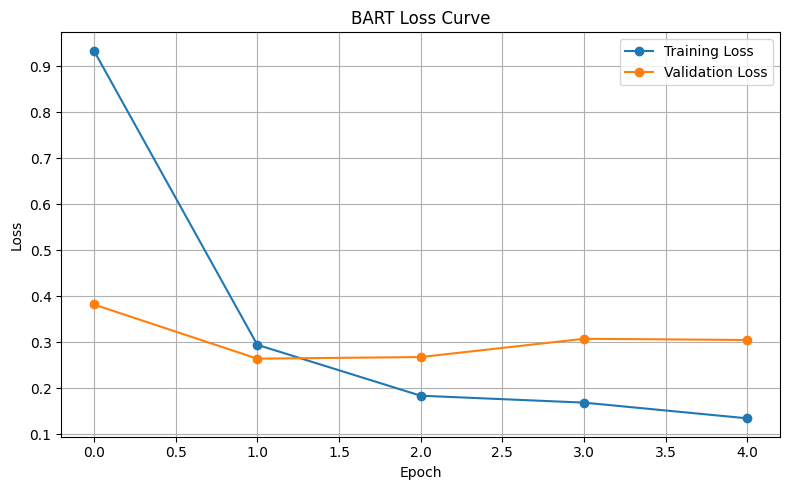

In [19]:
get_loss_curve(train_loss_log, val_loss_log, 'BART Loss Curve')

In [46]:
df_out = test(model, test_loader, tokenizer, 'bart_finetuned.pt')
df_out.to_csv('bart_predictions.csv', index=False)
print("Saved predictions to 'bart_predictions.csv'")

100%|██████████| 53/53 [00:41<00:00,  1.27it/s]

Saved predictions to 'bart_predictions.csv'


In [ ]:
try:
    df_out
except NameError:
    df_out = pd.read_csv("bart_predictions.csv")

rouge_l, bleu_4, bertscore = eval(df_test, df_out)
print(f"\nAverage ROUGE-L: {rouge_l:.4f}")
print(f"Average BLEU-4:  {bleu_4:.4f}")
print(f"Average BERTScore F1: {bertscore:.4f}")